[Click to open on colab](https://colab.research.google.com/drive/1pH0HZVzxtv_6uH2ZZbz65IOJ54vdZGct?usp=sharing) (If you are already in colab, don't click)

# Spark setup 


In [1]:
pip install pyspark

     |████████████████████████████████| 281.4 MB 36 kB/s 
     |████████████████████████████████| 198 kB 47.3 MB/s 
  Created wheel for pyspark: filename=pyspark-3.2.1-py2.py3-none-any.whl size=281853642 sha256=94f07e4921b12f2c7493a876ef1c22e07655b60ada4336fc04e031b2bdd74c0f
  Stored in directory: /root/.cache/pip/wheels/9f/f5/07/7cd8017084dce4e93e84e92efd1e1d5334db05f2e83bcef74f
Successfully built pyspark


In [2]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.config("spark.driver.memory", "8g").getOrCreate()
sc = spark.sparkContext

# Data 
In this section, we download and pre-process the data. At the end, by splitting the data to Train and test sets, we can build the model and apply collaborative filtering algorithms

## Downloading data

In [3]:
!wget http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Toys_and_Games_5.json.gz
!gunzip reviews_Toys_and_Games_5.json.gz

!wget http://deepyeti.ucsd.edu/jianmo/amazon/metaFiles2/meta_Toys_and_Games.json.gz
!gunzip meta_Toys_and_Games.json.gz

--2022-03-30 12:39:29--  http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Toys_and_Games_5.json.gz
Resolving snap.stanford.edu (snap.stanford.edu)... 171.64.75.80
Connecting to snap.stanford.edu (snap.stanford.edu)|171.64.75.80|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 42057555 (40M) [application/x-gzip]
Saving to: ‘reviews_Toys_and_Games_5.json.gz’

reviews_Toys_and_Ga 100%[===================>]  40.11M  4.43MB/s    in 14s     

2022-03-30 12:39:43 (2.84 MB/s) - ‘reviews_Toys_and_Games_5.json.gz’ saved [42057555/42057555]

--2022-03-30 12:39:44--  http://deepyeti.ucsd.edu/jianmo/amazon/metaFiles2/meta_Toys_and_Games.json.gz
Resolving deepyeti.ucsd.edu (deepyeti.ucsd.edu)... 169.228.63.50
Connecting to deepyeti.ucsd.edu (deepyeti.ucsd.edu)|169.228.63.50|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 808563982 (771M) [application/octet-stream]
Saving to: ‘meta_Toys_and_Games.json.gz’

meta_Toys_and_Games 100

## Data pre-processing

In [4]:
dataset_path = './reviews_Toys_and_Games_5.json'
rawdata = spark.read.json(dataset_path)
rawdata.show(n=10)
rawdata.count()

metadata_path = './meta_Toys_and_Games.json'
metadata = spark.read.json(metadata_path)

+----------+--------+-------+--------------------+-----------+--------------+--------------+--------------------+--------------+
|      asin| helpful|overall|          reviewText| reviewTime|    reviewerID|  reviewerName|             summary|unixReviewTime|
+----------+--------+-------+--------------------+-----------+--------------+--------------+--------------------+--------------+
|0439893577|  [0, 0]|    5.0|I like the item p...|01 29, 2014|A1VXOAVRGKGEAK|         Angie|      Magnetic board|    1390953600|
|0439893577|  [1, 1]|    4.0|Love the magnet e...|03 28, 2014| A8R62G708TSCM|       Candace|it works pretty g...|    1395964800|
|0439893577|  [1, 1]|    5.0|Both sides are ma...|01 28, 2013|A21KH420DK0ICA|capemaychristy|          love this!|    1359331200|
|0439893577|  [0, 0]|    5.0|Bought one a few ...| 02 8, 2014| AR29QK6HPFYZ4|          dcrm|   Daughters love it|    1391817600|
|0439893577|  [1, 1]|    4.0|I have a stainles...| 05 5, 2014| ACCH8EOML6FN5|          DoyZ|Great

Dropping unnessary columns

In [7]:
polished_rawdata_temp = rawdata.drop('helpful','reviewText','reviewTime','reviewerName','unixReviewTime','summary').withColumnRenamed('asin','itemID').withColumnRenamed('reviewerID','userID').withColumnRenamed("overall","rating")
polished_rawdata = polished_rawdata_temp.select("userID","itemID","rating") # reorder the columns
polished_rawdata.show(n=10)
print("Number of Unique users: ", polished_rawdata.select("userID").distinct().count())
print("Number of Unique items: ", polished_rawdata.select("itemID").distinct().count())


+--------------+----------+------+
|        userID|    itemID|rating|
+--------------+----------+------+
|A1VXOAVRGKGEAK|0439893577|   5.0|
| A8R62G708TSCM|0439893577|   4.0|
|A21KH420DK0ICA|0439893577|   5.0|
| AR29QK6HPFYZ4|0439893577|   5.0|
| ACCH8EOML6FN5|0439893577|   4.0|
|A1EDPGHC9EYBUN|0439893577|   3.0|
|A181ZNB42LISRZ|0439893577|   3.0|
|A1RBEJ5UQ1RWAW|0439893577|   5.0|
| AFGGC7SIV964O|0439893577|   4.0|
|A2XU46XXNV19C8|0439893577|   3.0|
+--------------+----------+------+
only showing top 10 rows

Number of Unique users:  19412
Number of Unique items:  11924


ALS only works with numerical values. Converting Strings to double with StringIndexer

In [8]:
from pyspark.ml.feature import StringIndexer
user_indexer = StringIndexer(inputCol="userID", outputCol="user")
indexed1 = user_indexer.fit(polished_rawdata).transform(polished_rawdata)
item_indexer = StringIndexer(inputCol="itemID", outputCol="item")
indexed2 = item_indexer.fit(indexed1).transform(indexed1)
data = indexed2.select("user","item","rating")

Showing the pre-processed data

In [9]:
data.show(5)

+-------+------+------+
|   user|  item|rating|
+-------+------+------+
|14349.0|2524.0|   5.0|
|18115.0|2524.0|   4.0|
| 4454.0|2524.0|   5.0|
|18990.0|2524.0|   5.0|
| 2769.0|2524.0|   4.0|
+-------+------+------+
only showing top 5 rows



## Train & Test Splitting

In [204]:
train, test = data.randomSplit([0.8, 0.2], seed=12345)


print('Train set size: {}'.format(train.count()))
print('Test set size: {}'.format(test.count()))


Train set size: 134088
Test set size: 33509


# ALS Algorithm

In this section, we apply ALS algorithm.
At first we tune the hyper Parameter.

## First Step of tuning

At the first step, we try these values for parameters:


```
als.rank = [1,5,10,50,70]
als.regParam = [0.05, 0.1 , 0.5, 5]
```
with `als.maxIter = 15`




The code below, split train data to train and validation sets and finds the validation set RMSE for every combination of hyperparameters


In [205]:
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit
from pyspark.sql import Row

als = ALS(userCol="user", itemCol="item", ratingCol="rating",coldStartStrategy='drop',nonnegative=False)
     
rmseevaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")

paramGrid = ParamGridBuilder()\
    .addGrid(als.rank, [1, 5, 10,50,70]) \
    .addGrid(als.maxIter, [15])\
    .addGrid(als.regParam, [0.05, 0.1, 0.5,5])\
    .build()

tvs = TrainValidationSplit(estimator=als,
                           estimatorParamMaps=paramGrid,
                           evaluator=rmseevaluator,
                           trainRatio=0.8)
tvsmodel = tvs.fit(train)
paramMap = list(zip(tvsmodel.validationMetrics,tvsmodel.getEstimatorParamMaps()))

Sorting to find the lowest value for RMSE

In [206]:
paramMap = sorted(paramMap, key=lambda x: x[0]) 
for i in paramMap:
  print(i)


(1.1275729894021274, {Param(parent='ALS_921c2ac8a2aa', name='rank', doc='rank of the factorization'): 5, Param(parent='ALS_921c2ac8a2aa', name='maxIter', doc='max number of iterations (>= 0).'): 15, Param(parent='ALS_921c2ac8a2aa', name='regParam', doc='regularization parameter (>= 0).'): 0.5})
(1.1284624015324007, {Param(parent='ALS_921c2ac8a2aa', name='rank', doc='rank of the factorization'): 10, Param(parent='ALS_921c2ac8a2aa', name='maxIter', doc='max number of iterations (>= 0).'): 15, Param(parent='ALS_921c2ac8a2aa', name='regParam', doc='regularization parameter (>= 0).'): 0.5})
(1.1289744998545796, {Param(parent='ALS_921c2ac8a2aa', name='rank', doc='rank of the factorization'): 70, Param(parent='ALS_921c2ac8a2aa', name='maxIter', doc='max number of iterations (>= 0).'): 15, Param(parent='ALS_921c2ac8a2aa', name='regParam', doc='regularization parameter (>= 0).'): 0.5})
(1.1290255741921804, {Param(parent='ALS_921c2ac8a2aa', name='rank', doc='rank of the factorization'): 50, Para

## ALS on Test set
Applying the tuned model on test data

In [207]:
predictions = tvsmodel.transform(test)
testset_rmse = rmseevaluator.evaluate(predictions)
print('Test set RMSE obtained by ALS (regParam = 0.5, rank = 10, maxIter = 15):' , (testset_rmse))
    

Test set RMSE obtained by ALS (regParam = 0.5, rank = 10, maxIter = 15): 1.0791912198581908


## No overfitting!



```
1.   Test set RMSE = 1.07

2.   Validation set RMSE = 1.12

```


Since test set RMSE < Validation set RMSE, It can be concluded that it's not a case of overfitting

## Second step of tuning
The results shows that `regParam = [0.5]` has the lowest RMSE. 
For the next step, We only tune this parameter with the following values:

`als.regParam =  [0.2,0.3,0.4,0.5]`

In [208]:
paramGrid2 = ParamGridBuilder()\
    .addGrid(als.rank, [50]) \
    .addGrid(als.maxIter, [15])\
    .addGrid(als.regParam, [0.2,0.3,0.4,0.5])\
    .build()

tvs2 = TrainValidationSplit(estimator=als,
                           estimatorParamMaps=paramGrid2,
                           evaluator=rmseevaluator,
                           trainRatio=0.8)
tvsmodel2 = tvs2.fit(train)
paramMap2 = list(zip(tvsmodel2.validationMetrics,tvsmodel2.getEstimatorParamMaps()))
 

Sorting to find the lowest value for RMSE

In [209]:
paramMap2 = sorted(paramMap2, key=lambda x: x[0]) 

for i in paramMap2:
  print(i)

(1.111008373771169, {Param(parent='ALS_921c2ac8a2aa', name='rank', doc='rank of the factorization'): 50, Param(parent='ALS_921c2ac8a2aa', name='maxIter', doc='max number of iterations (>= 0).'): 15, Param(parent='ALS_921c2ac8a2aa', name='regParam', doc='regularization parameter (>= 0).'): 0.3})
(1.11450222281313, {Param(parent='ALS_921c2ac8a2aa', name='rank', doc='rank of the factorization'): 50, Param(parent='ALS_921c2ac8a2aa', name='maxIter', doc='max number of iterations (>= 0).'): 15, Param(parent='ALS_921c2ac8a2aa', name='regParam', doc='regularization parameter (>= 0).'): 0.4})
(1.1168141206939664, {Param(parent='ALS_921c2ac8a2aa', name='rank', doc='rank of the factorization'): 50, Param(parent='ALS_921c2ac8a2aa', name='maxIter', doc='max number of iterations (>= 0).'): 15, Param(parent='ALS_921c2ac8a2aa', name='regParam', doc='regularization parameter (>= 0).'): 0.2})
(1.1290255741921804, {Param(parent='ALS_921c2ac8a2aa', name='rank', doc='rank of the factorization'): 50, Param(

Applying the new tuned model on test data

In [210]:
predictions2 = tvsmodel2.transform(test)
testset_rmse2 = rmseevaluator.evaluate(predictions2)
print('Test set RMSE obtained by ALS (regParam = 0.3, rank = 50, maxIter = 15):' , (testset_rmse2))


Test set RMSE obtained by ALS (regParam = 0.3, rank = 50, maxIter = 15): 1.0527747390193145


Second step tuning reduced RMSE by 0.02!

# Global Mean Recommender System 
To compare our model, we build a recommender system based on global ratings mean

## Calculating Training set Mean and RMSE based on that

In [211]:
from math import sqrt

ratingCol_pdf = train.describe("rating").toPandas()
train_rating_mean = float(ratingCol_pdf["rating"][1])
base_mse = test.rdd.map(lambda t : (train_rating_mean - (int)(t['rating'])) ** 2).mean()
print(base_mse , sqrt(base_mse))

1.0017696184144673 1.0008844181095373


As our data only contains Integer as ratings `[1.0 , 2.0 , 3.0 , 4.0 , 5.0]`, rounding training mean to the closest integer might help

In [222]:
train_rating_mean_round = round(train_rating_mean)
round_base_mse = test.rdd.map(lambda t : (train_rating_mean_round - (t['rating'])) ** 2).mean()
print(round_base_mse , sqrt(round_base_mse))

4.358018614641131
1.1238174818705409 1.060102580824394


Rounding the mean to the closest integer didn't help.
But !! ***Global Mean, worked better than ALS in our dataset.***


Now we try to investigate the distibution of ratings.






## **Distribution Of Ratings**
In this part, we try to find the distributions of ratings to check wheter is there any tendency or bias towards some ratings



Total Number of Reviews:  167597
Total Number of Users:  19412
Total Number of Items:  11924
Number of missing datas: 231301091


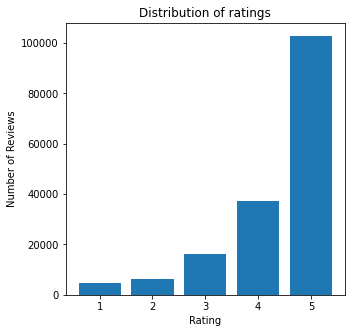

In [223]:
totalReviews = data.count()

print("Total Number of Reviews: ", totalReviews)
userCount = data.select("user").distinct().count()
itemCount = data.select("item").distinct().count()
print('Total Number of Users: ', userCount)
print('Total Number of Items: ', itemCount)
numOfZeros = userCount * itemCount - totalReviews;
print('Number of missing datas:' , numOfZeros)
stats = data.groupBy("rating").count().sort(['rating'])
stats = stats.collect()


import matplotlib.pyplot as plt
names = []
values = []
for i in stats : 
  names.append(i['rating'])
  values.append(i['count'])

plt.bar(names,values,label = 'Ratings')


# The following commands add labels to our figure.
plt.xlabel('Rating')
plt.ylabel('Number of Reviews')
plt.title('Distribution of ratings')

plt.show()

As depicted above, clearly, users tend to generally choose higher ranks (5.0 in our dataset) for the items. According to this conclusion, we'll be able to build an extended version of ALS which considers this bias




# ALS with Bias
Global Maen worked better than our ALS. In this section, we aim to build extended version of ALS which considers bias

## Rating manupliation
For this part, we maniuplate the ratings by following formula:

**newRating = currentRating - userMean - itemMean + train_rating_mean**

In [235]:
def ALSwithBias(input_train,input_test):
  
  ratingCol_pdf = input_train.describe("rating").toPandas()
  input_train_rating_mean = float(ratingCol_pdf["rating"][1])
  

  user_mean = input_train.groupby("user").avg("rating").withColumnRenamed("avg(rating)", "user_mean")
  item_mean = input_train.groupby("item").avg("rating").withColumnRenamed("avg(rating)", "item_mean")
  j1 = input_train.join(user_mean, "user", "inner")
  j2 = j1.join(item_mean, "item", "inner")

  final = j2.withColumn("rating_noBias", j2.rating - j2.user_mean - j2.item_mean + input_train_rating_mean)

  als = ALS(maxIter=15, rank=50, regParam=0.3, userCol="user", itemCol="item", ratingCol="rating_noBias",
              coldStartStrategy="drop")
  model = als.fit(final)

  tj1 = input_test.join(user_mean, "user", "inner")
  tj2 = tj1.join(item_mean, "item", "inner")
  test_final = tj2.withColumn("rating_noBias", tj2.rating - tj2.user_mean - tj2.item_mean + train_rating_mean)

  predictions = model.transform(test_final)
  evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating_noBias",
                                  predictionCol="prediction")
  rmse = evaluator.evaluate(predictions)
  return rmse


## Testing the ALSwithBias 
Calulcating the RMSE for our extended ALS

In [236]:
rmse_biased =  ALSwithBias(train,test)
print(rmse_biased)


0.9824600129695049


**ALS with bias, worked better than all the previous methods.** 



```
ALSwithBias RMSE = 0.98
```



## Can time induce temporal biases?
Time can sometimes acts as bias indicator, considering the fact that we have 14 years of reviews, some years might have higher average reviews.

To answer such question, the timestamps must be devided into multiple chunks and the average rating for each chunk must be found.

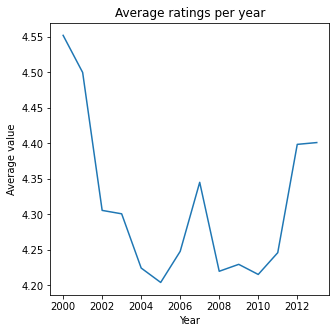

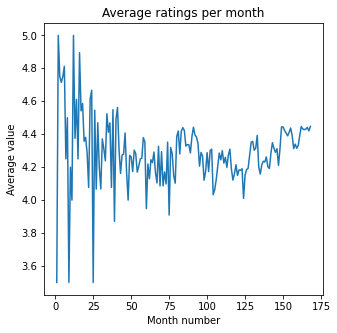

In [242]:
import numpy as np
from pyspark.sql.functions import col
from pyspark.sql.functions import udf
from pyspark.sql.types import IntegerType

new_polish = rawdata.drop('helpful','reviewText','reviewTime','reviewerName','summary').withColumnRenamed('asin','itemID').withColumnRenamed('reviewerID','userID').withColumnRenamed("overall","rating")
minTS = new_polish.agg({'unixReviewTime': 'min'}).collect()[0][0]
maxTS = new_polish.agg({'unixReviewTime': 'max'}).collect()[0][0]

#Since we have data for 14 years: 
TSyears = np.linspace(minTS,maxTS,14 + 1) #Timestamps for each year
TSMonth = np.linspace(minTS,maxTS,14 * 12 + 1) #Timestamps for each month



def findYearlyChunk(ts):
  index = 0
  for i in TSyears : 
    if (ts <= TSyears[index + 1]) : 
        return index + 1
    index += 1

def findMonthlyChunk(ts):
  index = 0
  for i in TSMonth : 
    if (ts <= TSMonth[index + 1]) : 
        return index + 1
    index += 1
    

yearUDF = udf(lambda ts: findYearlyChunk(ts),IntegerType())
monthUDF = udf(lambda ts: findMonthlyChunk(ts),IntegerType())

TSchunkTemp = new_polish.withColumn('TSChunkY', yearUDF(new_polish.unixReviewTime))
TSchunkAdded = TSchunkTemp.withColumn('TSChunkM', monthUDF(new_polish.unixReviewTime))

yearlyChunks = TSchunkAdded.groupBy('TSChunkY').avg('rating').sort(['TSChunkY'])
yearlyStats = yearlyChunks.collect()

monthlyChunks = TSchunkAdded.groupBy('TSChunkM').avg('rating').sort(['TSChunkM'])
monthlyStats = monthlyChunks.collect()

x = []
y = []
for i in yearlyStats : 
  x.append(i['TSChunkY'] +  1999) #Because the first year is 2000
  y.append(i['avg(rating)'] ) 
plt.plot(x, y)  
plt.title("Average ratings per year")
plt.xlabel('Year')
plt.ylabel('Average value')
plt.show()


x = []
y = []
for i in monthlyStats : 
  x.append(i['TSChunkM'])
  y.append(i['avg(rating)'])
plt.plot(x, y)  
plt.title("Average ratings per month")
plt.xlabel('Month number')
plt.ylabel('Average value')
plt.show()


According to the plots above, it appears that the rating average has seen very slight fluctuations in the 14 years period.

# KNN
Since Spark doesn't provide KNN library, we have to use scikit learn and in order to do so, we convert spark dataframe to panda's dataframe.


## Data pre-processing for KNN
To perform KNN on scikit learn, we must truncate our data to create our Utility Matrix. For this task, we only consider items which have more than `MIN_REVIEWS_PER_ITEM_THRESHOLD` number of reviews.

In [227]:
from pyspark.sql.functions import *

reviewsCountforEachItem = polished_rawdata.groupBy("itemID").count()
joined = polished_rawdata.join(reviewsCountforEachItem, "itemID" , "inner")

MIN_REVIEWS_PER_ITEM_THRESHOLD = 50
filtered_rawdata = joined.where(col("count") > MIN_REVIEWS_PER_ITEM_THRESHOLD)
panda_df = filtered_rawdata.withColumnRenamed("itemID","item").withColumnRenamed("userID","user").toPandas()
utilityMatrix =  panda_df.pivot(index='item', columns='user', values='rating').fillna(0)


## Building KNN model
Fitting the model to sparse utility matrix

In [228]:
from scipy.sparse import csr_matrix
sparseMatrix = csr_matrix(utilityMatrix.values)

from sklearn.neighbors import NearestNeighbors 
model_knn = NearestNeighbors(metric = 'cosine', algorithm = 'brute')
model_knn.fit(sparseMatrix) 

NearestNeighbors(algorithm='brute', metric='cosine')

## Recommendation based on user favorite item

In the example below, we assume that user inputs his favorite item (index for now) and our system recommends items based on the user input.

In [229]:
import numpy as np

def printNameByAsin(asin):
  return (metadata.where(col('asin') == asin).select("title").collect()[0][0])


favItem = 334


distances, indices = model_knn.kneighbors(utilityMatrix.iloc[favItem,:].values.reshape(1, -1), n_neighbors = 5)
for dist in range(0, len(distances.flatten())):
    if dist == 0:
        print('Recommendations for the game ', printNameByAsin(utilityMatrix.index[favItem]))
        print('\n')
    else:
        print(dist, ":", printNameByAsin(utilityMatrix.index[indices.flatten()[dist]]), ", distance: ", distances.flatten()[dist])



Recommendations for the game  Crayola See Thru Light Designer (74-7051)


1 : Crayola Create 2 Destroy Dino Destruction Stomping Mall , distance:  0.4942060943808445
2 : Crayola Doodle Magic Color Mat , distance:  0.5388895238198629
3 : Crayola Color Wonder Disney Princess Glitter Paper and Markers , distance:  0.5712727140857697
4 : SmartLab Toys Demolition Lab Triple Blast Warehouse , distance:  0.6287682790866542


## Predicting values using KNN


After finding K-nearest neighbors, we can predict values inside utility Matrix.

In the example below, we assume that one of the available values inside utility matrix is missing.

In [203]:
rndItem = 280
rndUser = 2119  
goal = utilityMatrix.iloc[rndItem,rndUser]
print("We aim to predict a missing value in utlity Matrix whish is = ", goal)


distances, indices = model_knn.kneighbors(utilityMatrix.iloc[rndItem,:].values.reshape(1, -1), n_neighbors = 25)
numerator = 0
denominator = 0
for dist in range(0, len(distances.flatten())):
    if dist == 0:
       pass
    else:
        neighbor_index = indices.flatten()[dist]
        item_simiiarity = 1 - distances.flatten()[dist]
        temp = utilityMatrix.iloc[rndItem,neighbor_index]
        
        if (temp > 0 ) : 

          numerator += temp * item_simiiarity 
          denominator += item_simiiarity 



if (numerator > 0) : 
  prediction = (numerator / denominator)
  print("Our prediction for the missing value was", prediction)

else : print("Not enough data")

from math import sqrt
rmse_for_this_example = sqrt(((goal - prediction) ** 2) / 1.0)
print("RSME for this example = ", rmse_for_this_example)

        
 


We aim to predict a missing value in utlity Matrix whish is =  4.0
Our prediction for the missing value was 5.0
RSME for this example =  1.0


# Sub-sampling
For the last section, we subsample our dataset

## Visualization 
Sub-sampling allows us visualize our data.

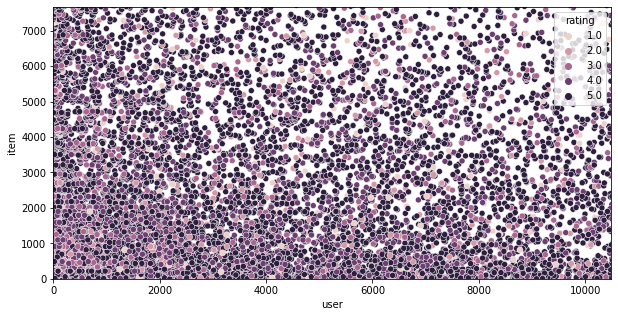

In [32]:
sampled = data.sample(0.1)
userCount = sampled.select("user").distinct().count()
itemCount = sampled.select("item").distinct().count()

panda_sampled = sampled.toPandas()


import seaborn as sns
sns.scatterplot(data=panda_sampled, x="user", y="item", hue="rating")
plt.xlim(0,userCount) 
plt.ylim(0,itemCount)  
plt.rcParams["figure.figsize"] = (5,5)
plt.show()




## ALSwithBias on sub-sample of training set
In the last part of this notebook, we evaluate the performance of AlSwithBias on samples of training set

In [243]:
fractions = [0.01,0.1,0.5,0.8,0.99]

errors = []
for f in fractions:
  errors.append(ALSwithBias(train.sample(f,seed = 10) , test))

In [245]:
print(errors)

[1.337143093673943, 1.2768679129006901, 1.1069375872209488, 1.0186520295277461, 0.9837123441262384]


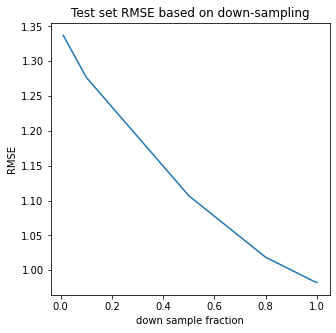

In [250]:
plt.plot(fractions, errors)
plt.title("Test set RMSE based on down-sampling")
plt.xlabel('down sample fraction')
plt.ylabel('RMSE')
plt.show()

Down-sampling didn't work. In collaborative filtering, down-sampling makes the utlity matrix more sparse and it leads to higher value for RMSE